In [1]:
%matplotlib inline
import utils; reload(utils)
from random import randint
from utils import *

Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)
Using Theano backend.


In [2]:
path = 'data/fishes/'
full_path = os.getcwd() + '/' + path

In [3]:
batch_size = 64

In [38]:
VERSION = 'mltibb_005_t1'

### To do list:

1. Create validation set and sample
2. Move to separate dirs for each set
3. Finetune and train
4. Submit to kaggle

In [5]:
classes = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']

# Finetune and train

In [6]:
batches = get_batches(path+'train', batch_size=batch_size)
val_batches = get_batches(path+'valid', batch_size=batch_size*2, shuffle=False)

(val_classes, trn_classes, val_labels, trn_labels, 
    val_filenames, filenames, test_filenames) = get_classes(path)

Found 2573 images belonging to 8 classes.
Found 563 images belonging to 8 classes.
Found 2573 images belonging to 8 classes.
Found 563 images belonging to 8 classes.
Found 154 images belonging to 1 classes.


In [7]:
raw_filenames = [f.split('/')[-1] for f in filenames]
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]
raw_val_filenames = [f.split('/')[-1] for f in val_filenames]

Load data from files

In [34]:
trn = load_array(path + 'results/trn.dat')

KeyboardInterrupt: 

In [8]:
val = load_array(path + 'results/val.dat')

In [36]:
test = load_array(path + 'results/test.dat')

### Precompute convolutional output

We pre-compute the output

In [9]:
from vgg16bn import Vgg16BN
model = vgg_ft_bn(8)

In [10]:
conv_layers, fc_layers = split_at(model, Convolution2D)

In [11]:
conv_model = Sequential(conv_layers)

### Load precomputed conv. output

In [12]:
conv_feat = load_array(path+'results/conv_feat.dat')
conv_val_feat = load_array(path+'results/conv_val_feat.dat')
conv_test_feat = load_array(path+'results/conv_test_feat.dat')

In [13]:
conv_val_feat.shape

(563, 512, 14, 14)

# Bounding boxes

In [14]:
import json

In [15]:
anno_classes = ['alb', 'bet', 'dol', 'lag', 'other', 'shark', 'yft']

In [16]:
bb_json = {}
for anno_class in anno_classes:
    annotations = json.load(open(path + 'bb/{}_labels.json'.format(anno_class), 'r'))
    for annotation in annotations:
        if len(annotation['annotations']) > 0:
            bb_json[annotation['filename'].split('/')[-1]] = sorted(
                annotation['annotations'],
                key=lambda x: x['height']*x['width']
            )[-1]

In [17]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [18]:
file2idx = {o:i for i,o in enumerate(raw_filenames)}
val_file2idx = {o:i for i,o in enumerate(raw_val_filenames)}

In [19]:
empty_bbox = {'height': 0., 'width': 0., 'x': 0., 'y': 0.}

In [20]:
for f in raw_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox
for f in raw_val_filenames:
    if not f in bb_json.keys():
        bb_json[f] = empty_bbox

In [21]:
bb_params = ['height', 'width', 'x', 'y']
def convert_bb(bb, size):
    bb = [bb[p] for p in bb_params]
    conv_x = (224. / size[0])
    conv_y = (224. / size[1])
    bb[0] = bb[0]*conv_y
    bb[1] = bb[1]*conv_x
    bb[2] = max(bb[2]*conv_x, 0)
    bb[3] = max(bb[3]*conv_y, 0)
    return bb

In [22]:
sizes = [PIL.Image.open(path+'train/'+f).size for f in filenames]
id2size = list(set(sizes))
size2id = {o:i for i,o in enumerate(id2size)}
trn_sizes_orig = to_categorical([size2id[o] for o in sizes], len(id2size))
raw_val_sizes = [PIL.Image.open(path+'valid/'+f).size for f in val_filenames]
val_sizes = to_categorical([size2id[o] for o in raw_val_sizes], len(id2size))
trn_sizes = trn_sizes_orig-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)
val_sizes = val_sizes-trn_sizes_orig.mean(axis=0)/trn_sizes_orig.std(axis=0)

In [23]:
bb_json['img_04908.jpg']

{u'class': u'rect',
 u'height': 246.75000000000074,
 u'width': 432.8700000000013,
 u'x': 465.3000000000014,
 u'y': 496.32000000000147}

In [24]:
val_file2idx['img_04908.jpg']

534

In [25]:
val_labels[val_file2idx['img_04908.jpg']]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.])

In [84]:
def create_rect(bb, color='red'):
    return plt.Rectangle((bb[2], bb[3]), bb[1], bb[0], color=color, fill=False, lw=3, linestyle='dotted')

def show_bb(i):
    bb = val_bbox[i]
    plot(val[i])
    plt.gca().add_patch(create_rect(bb))
    plt.axis('off')

In [85]:
trn_bbox = np.stack([convert_bb(bb_json[f], s) for f,s in zip(raw_filenames, sizes)], 
                   ).astype(np.float32)
val_bbox = np.stack([convert_bb(bb_json[f], s) 
                   for f,s in zip(raw_val_filenames, raw_val_sizes)]).astype(np.float32)

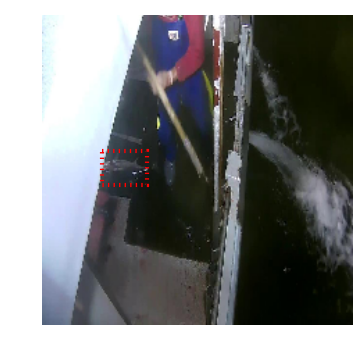

In [87]:
show_bb(100)

In [33]:
trn_bbox

array([[  19.5795,   29.5077,   61.5091,  135.2092],
       [  41.6889,    9.1   ,   67.55  ,  119.7778],
       [  31.5097,   20.7147,   93.9185,   68.3231],
       ..., 
       [  23.3333,   41.65  ,   36.925 ,  126.3111],
       [  59.7947,   75.6   ,   80.85  ,  115.9097],
       [  24.9527,   35.0385,   68.8432,   10.5964]], dtype=float32)

# Train model


In [32]:
p = 0.45  # dropout

In [33]:
inp = Input(conv_layers[-1].output_shape[1:])

x = MaxPooling2D()(inp)
x = BatchNormalization(axis=1)(x)
x = Dropout(p/4)(x)
x = Flatten()(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p)(x)

x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(p/2)(x)

x_bb = Dense(4, name='bb')(x)
x_class = Dense(8, activation='softmax', name='class')(x)

In [34]:
model = Model([inp], [x_bb, x_class])
model.compile(
    Adam(lr=0.001),
    loss=['mse', 'categorical_crossentropy'],
    metrics=['accuracy'],
    loss_weights=[.001, 1.],
)

In [35]:
model.fit(
    conv_feat,
    [trn_bbox, trn_labels],
    batch_size=batch_size,
    nb_epoch=3,
    validation_data=(conv_val_feat, [val_bbox, val_labels]),
)

Train on 2573 samples, validate on 563 samples
Epoch 1/3
2573/2573 [==============================] - 2s - loss: 6.0509 - bb_loss: 4996.3481 - class_loss: 1.0545 - bb_acc: 0.3949 - class_acc: 0.7023 - val_loss: 5.2973 - val_bb_loss: 4165.0563 - val_class_loss: 1.1322 - val_bb_acc: 0.5595 - val_class_acc: 0.8401
Epoch 2/3
2573/2573 [==============================] - 2s - loss: 4.9418 - bb_loss: 4735.1936 - class_loss: 0.2066 - bb_acc: 0.4870 - class_acc: 0.9436 - val_loss: 4.2080 - val_bb_loss: 3833.0849 - val_class_loss: 0.3749 - val_bb_acc: 0.6181 - val_class_acc: 0.9343
Epoch 3/3
2573/2573 [==============================] - 2s - loss: 4.4560 - bb_loss: 4339.9427 - class_loss: 0.1161 - bb_acc: 0.5251 - class_acc: 0.9670 - val_loss: 3.8130 - val_bb_loss: 3472.4968 - val_class_loss: 0.3405 - val_bb_acc: 0.6359 - val_class_acc: 0.9378


In [36]:
model.optimizer.lr = 1e-5

In [37]:
model.fit(
    conv_feat,
    [trn_bbox, trn_labels],
    batch_size=batch_size,
    nb_epoch=10,
    validation_data=(conv_val_feat, [val_bbox, val_labels]),
)

Train on 2573 samples, validate on 563 samples
Epoch 1/10
2573/2573 [==============================] - 2s - loss: 3.8964 - bb_loss: 3836.4662 - class_loss: 0.0600 - bb_acc: 0.5628 - class_acc: 0.9868 - val_loss: 3.5032 - val_bb_loss: 3261.6449 - val_class_loss: 0.2416 - val_bb_acc: 0.6252 - val_class_acc: 0.9609
Epoch 2/10
2573/2573 [==============================] - 2s - loss: 3.3231 - bb_loss: 3272.7539 - class_loss: 0.0503 - bb_acc: 0.6032 - class_acc: 0.9891 - val_loss: 3.2120 - val_bb_loss: 2969.3219 - val_class_loss: 0.2427 - val_bb_acc: 0.6483 - val_class_acc: 0.9627
Epoch 3/10
2573/2573 [==============================] - 2s - loss: 2.6891 - bb_loss: 2636.1539 - class_loss: 0.0530 - bb_acc: 0.6393 - class_acc: 0.9860 - val_loss: 2.5926 - val_bb_loss: 2339.0806 - val_class_loss: 0.2535 - val_bb_acc: 0.6767 - val_class_acc: 0.9556
Epoch 4/10
2573/2573 [==============================] - 2s - loss: 2.0024 - bb_loss: 1953.7446 - class_loss: 0.0486 - bb_acc: 0.6712 - class_acc: 0.9864

In [39]:
model.save_weights(path+'models/multi_conv_512_6_{}.h5'.format(VERSION))

In [40]:
model.evaluate(conv_val_feat, [val_bbox, val_labels])

563/563 [==============================] - 0s     


[0.4799064078217713,
 239.54382187350393,
 0.24036257272662942,
 0.84547069292932375,
 0.96980461811722918]

In [41]:
model.load_weights(path+'models/multi_conv_512_6_{}.h5'.format(VERSION))

# Box prediction visualization

In [90]:
pred = model.predict(conv_val_feat)

In [91]:
val_labels[2]

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [94]:
def show_bb_pred(i):
    bb = val_bbox[i]
    bb_pred = pred[0][i]
    plt.figure(figsize=(6,6))
    plt.axis('off')
    plot(val[i])
    ax=plt.gca()
    ax.add_patch(create_rect(bb, 'red'))
    ax.add_patch(create_rect(bb_pred, 'limegreen'))


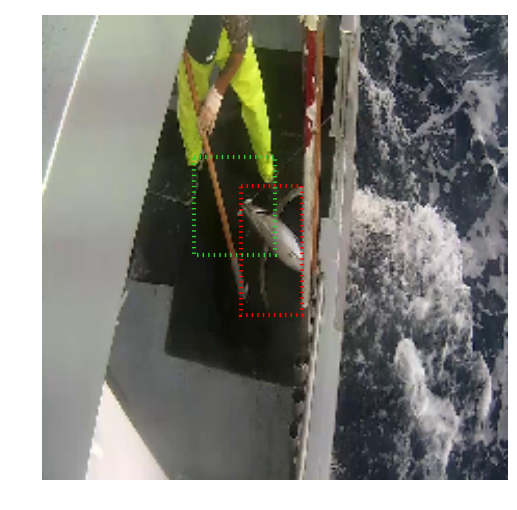

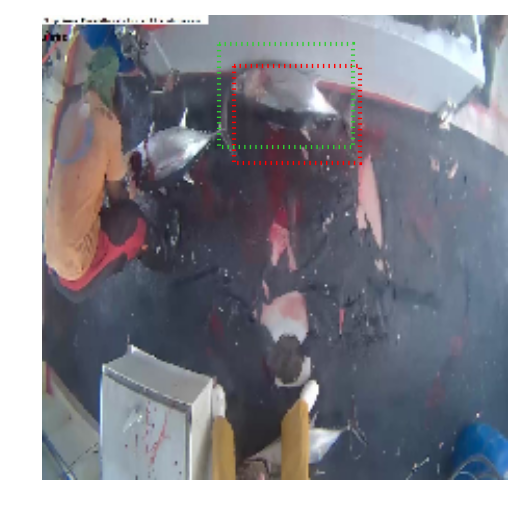

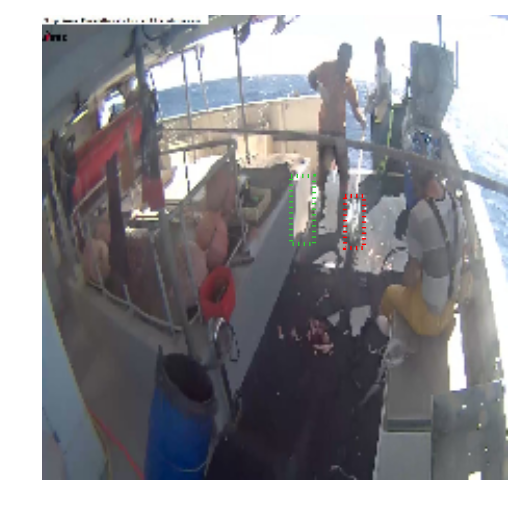

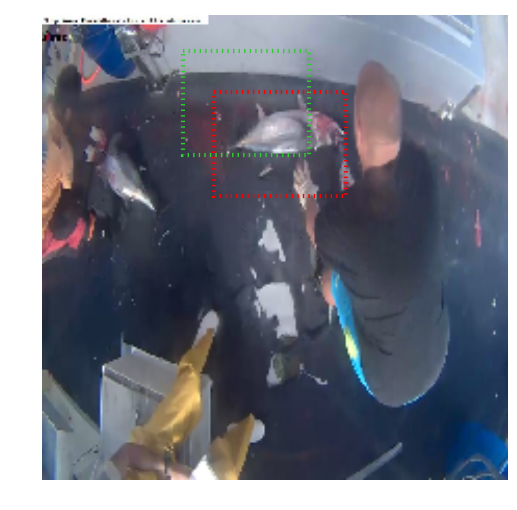

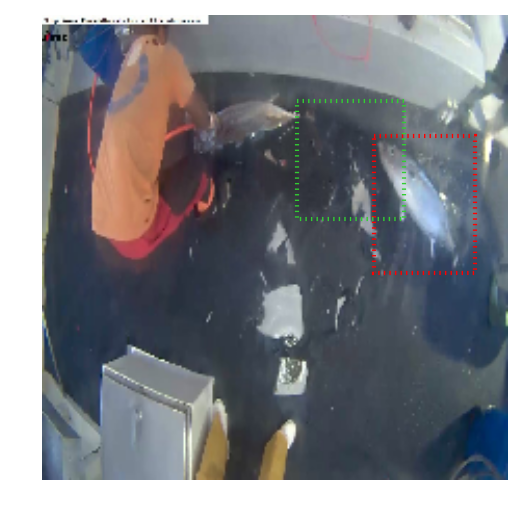

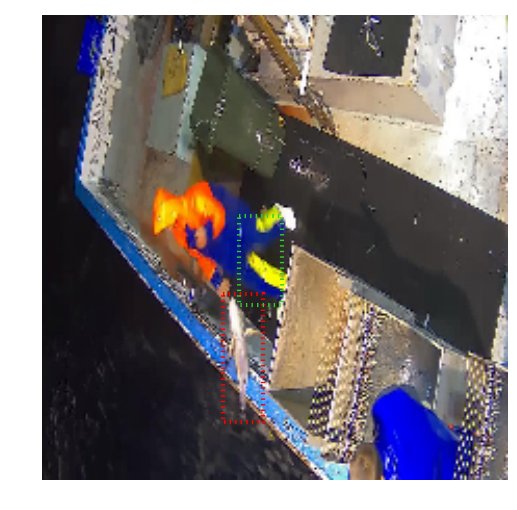

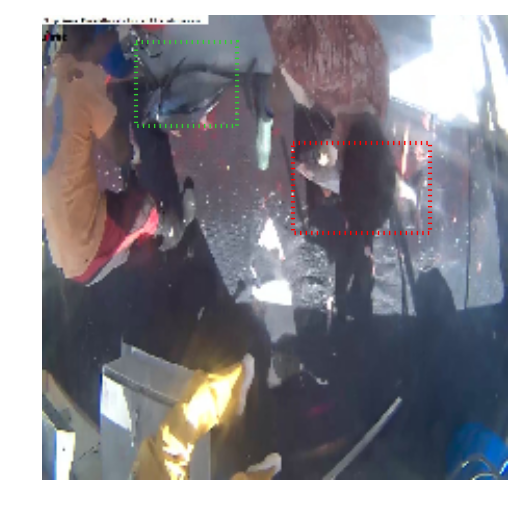

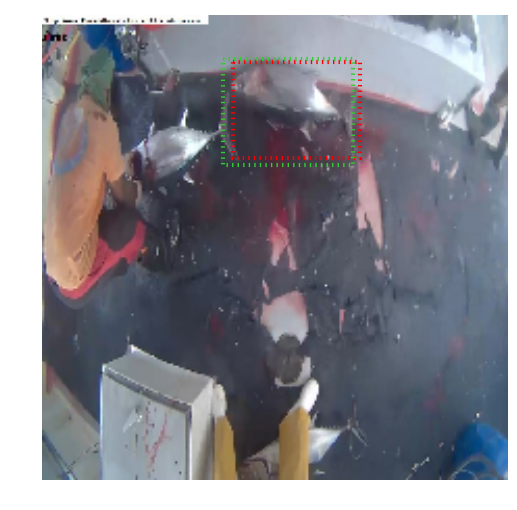

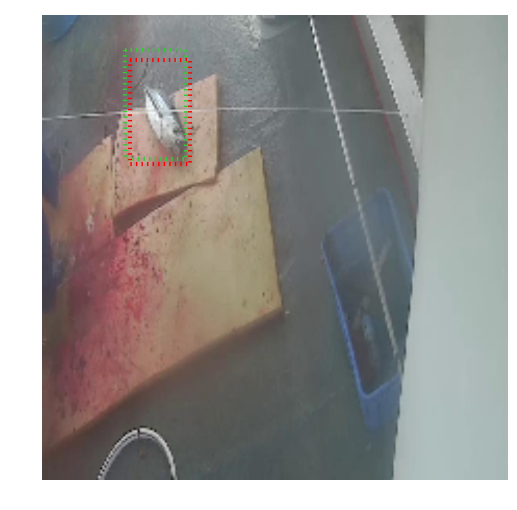

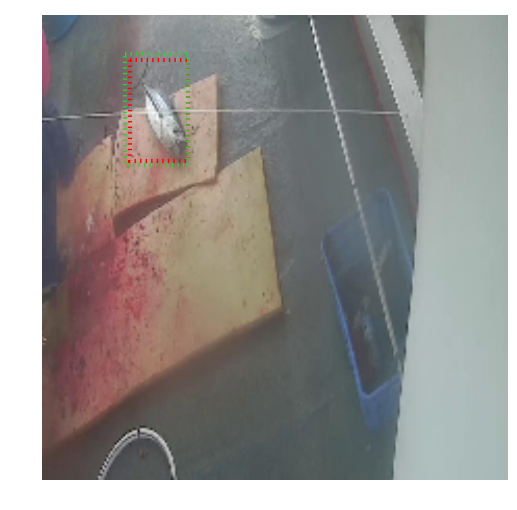

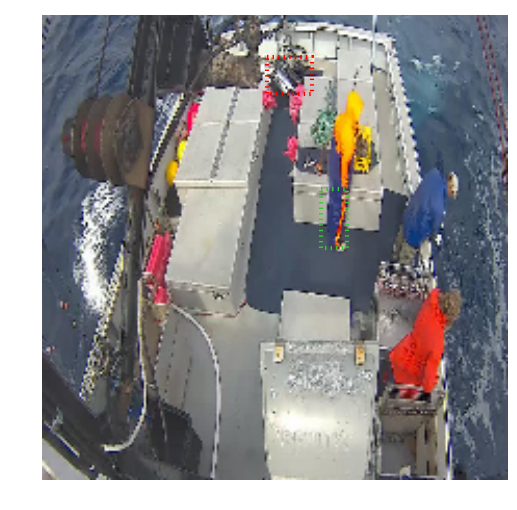

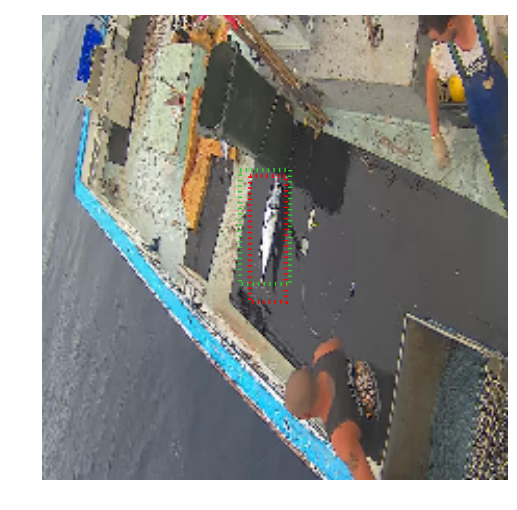

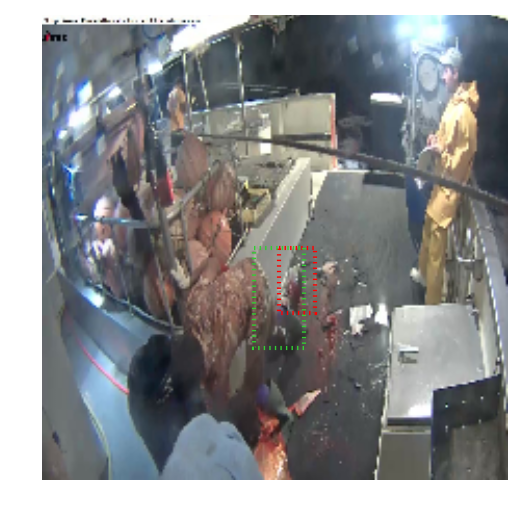

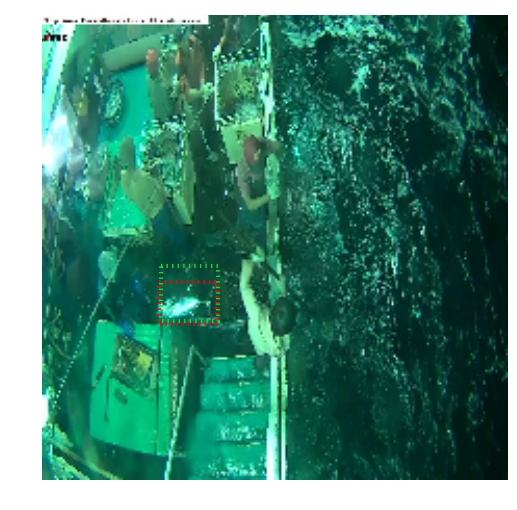

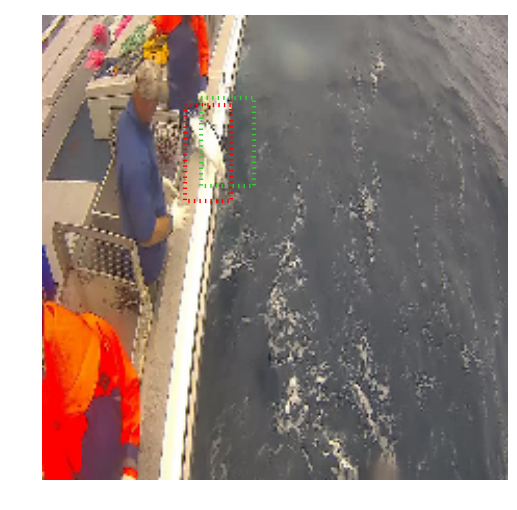

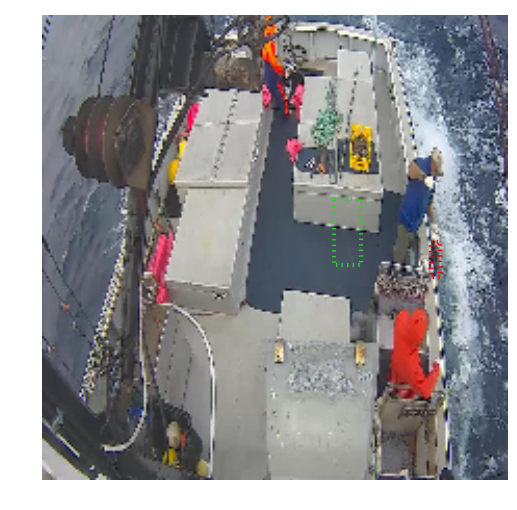

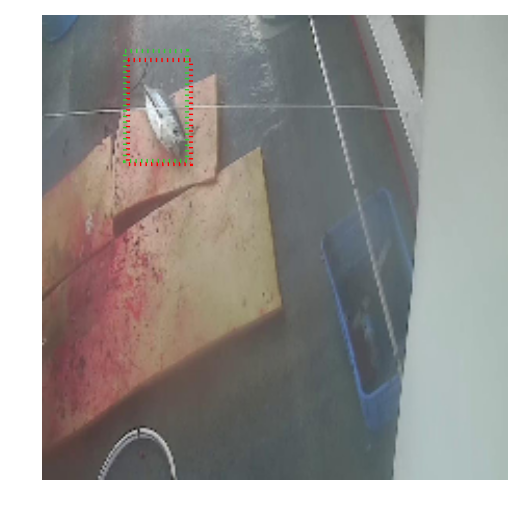

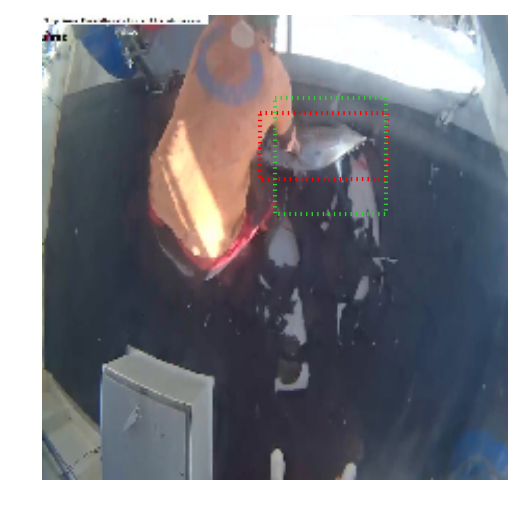

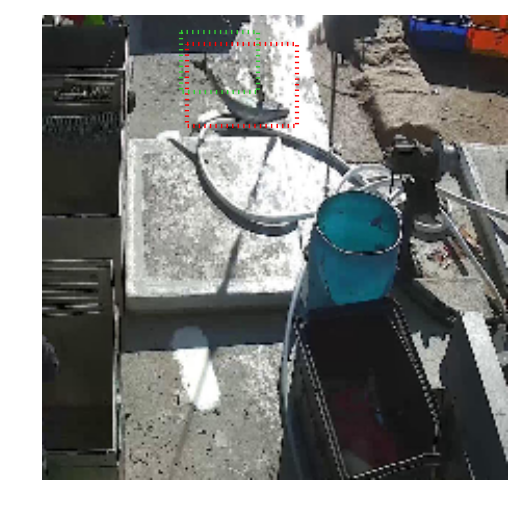

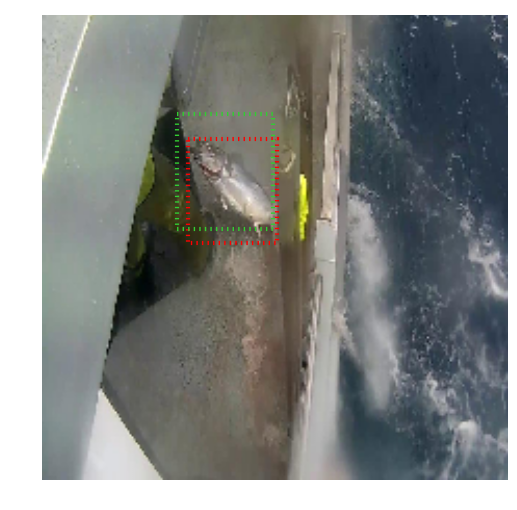

In [101]:
x=20 * 11
for n in range(x, x+20):
    show_bb_pred(n)


# Submit

In [171]:
test = load_array(path+'results/test.dat')

In [177]:
#test_batches = get_batches(path + 'test', shuffle=False)
preds = model.predict(conv_test_feat, batch_size=batch_size)

We need only the class predictions

In [178]:
preds = preds[1]

In [179]:
def do_clip(arr, mx):
    return np.clip(arr, (1-mx)/7, mx)

In [180]:
subm = do_clip(preds, 0.85)
raw_test_filenames = [f.split('/')[-1] for f in test_filenames]


In [181]:
subm_name = path+'results/subm_bb_dp_{}.gz'.format(VERSION)

In [182]:
submission = pd.DataFrame(subm, columns=classes)
submission.insert(0, 'image', raw_test_filenames)
submission.head()

image       ALB       BET       DOL       LAG       NoF     OTHER  \
0  img_06237.jpg  0.850000  0.021429  0.021429  0.021429  0.021429  0.021429   
1  img_06893.jpg  0.850000  0.021429  0.021429  0.021429  0.021429  0.021429   
2  img_02082.jpg  0.751757  0.021429  0.021429  0.021429  0.220194  0.021429   
3  img_06261.jpg  0.850000  0.021429  0.021429  0.021429  0.021429  0.021429   
4  img_03628.jpg  0.850000  0.021429  0.021429  0.021429  0.021429  0.021429   

      SHARK       YFT  
0  0.021429  0.021429  
1  0.021429  0.021429  
2  0.021429  0.021429  
3  0.021429  0.021429  
4  0.021429  0.021429

In [183]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [184]:
FileLink(subm_name)

/home/ubuntu/nbs/data/fishes/results/subm_bb_dp_mltibb_005.gz